<a href="https://colab.research.google.com/github/krbe9202/Deep-learning/blob/master/Deep_learning_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep learning HT19 - Laboration 1

Laboration 1 aims to create a Convolutional Neural Network (CNN) model to classify the images in the MNIST fashion data set. 

The data set consists of 70 000 grayscale images, with resolution 28x28 pixels, where of 60 000 are training images and 10 000 are test images. There are 10 categories of clothing including shirts, trousers, pullovers, dresses, coats, bags and different types of shoes. 

I have segmented the assignment and each segment includes a brief explanation of the code. The results and discussion are presented at the end. Let's start by loading the MNIST fashion data and pre-processing it a bit.   





In [67]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
# tf.compat.v1.enable_eager_execution()  # if using Model subclassing
print(tf.__version__)
print(tf.executing_eagerly())

mnist_fashion = tf.keras.datasets.fashion_mnist

(train_images,train_labels),(test_images,test_labels) = mnist_fashion.load_data()

# the 10 classes of clothing, used for plotting
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# scale values to range from 0 to 1
train_images, test_images = (train_images / 255.0), (test_images / 255.0)
# one hot encode target column
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# add a channels dimension
train_images = train_images[...,tf.newaxis]
test_images = test_images[...,tf.newaxis]



1.15.0
False


**Data augmentation**  

The idea behind data augmentation is creating more training examples by taking the existing ones and performing image transformations such as rotation, shearing, translation, zooming and so on. Here, this is done by using ImageDataGenerator. 


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


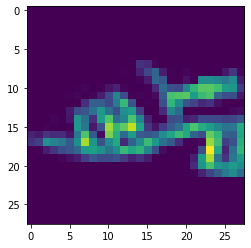

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

data_aug = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

train_generator=data_aug.flow(
    train_images, 
    train_labels, 
    batch_size=32,
    shuffle=True)

# inspect augmented images
plt.imshow(np.squeeze(train_generator[0][0][0]))



**Function to build models**

This function builds the CNN Sequential model and it utilises max pooling and, if desired, droupout and batch normalization. Max pooling is a sample-based discretization process where the input is down-sampled, reducing its dimensionality. This helps with over-fitting by providing an abstracted form of representation as well as reducing computational costs by decreasing the amount of lernable parameters. It is usually done by applying a max filter to subregions of the initial representation. Dropout is a regularization method and can be applied to both input layers and the hidden layers. It randomly masks the outputs of a fraction of units from a layer by setting their output to zero. Batch normalization is technique, usually applied for deep or very deep NNs, that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks. 


*Required arguments for the function*

**k_size:** tuple, specifying the kernel size. 

**stride:** int, specifying the pace at which the kernel is transversed over the image. 

**use_bn:** boolean, specifying if batch normalization should be used or not. 

**use_dp:** boolean, specifying if drop out should be used or not. 

**num_classes:** int, the number of classes we want to classify. In our case, this is 10. 


In [0]:

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization, InputLayer
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam

in_shape=train_images[0,:].shape

def build(k_size:tuple, stride:int,
          use_bn:bool, use_dp:bool, num_classes:int):
  # initiate model
  model=Sequential()
  # add first convolutional layer
  model.add(Conv2D(32, k_size, stride, padding='same', activation='relu', 
                   kernel_initializer='he_uniform',
                   input_shape=in_shape))
  if use_bn:
    model.add(BatchNormalization(axis=-1))
  # add second convolutional layer
  model.add(Conv2D(64, k_size, stride, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if use_dp: 
    model.add(Dropout(0.25))
  # add third convolutional layer
  model.add(Conv2D(64, k_size, stride, padding='same', activation='relu'))
  # add fully connected layer
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  if use_dp: 
    model.add(Dropout(0.5))
  # add output layer with 10 nodes for classification
  model.add(Dense(10, activation="softmax"))
  
  model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4), 
              metrics=["accuracy"])
  return model



**Train model and evaluate model performance**

I performed some experiments with kernel size, stride, batch size (i.e. the total number of images passed to the model per iteration), dropout (fraction and position) and batch normalization (position) (see Results and Discussion). 

An alternative could be to use cross validation and split the training data into two (training and validation), and then use the external test data for performance evaluation. However, hyperparameter optimization using cross validation is not really optimal for CNNs as they typically  have a large amount of parameters (e.g. more than one million). 

In [93]:

BS = 64
EPOCHS=50

# train a model 
def train(model,train_x, train_y, test_x, test_y):
    scores, histories = list(), list()

    # either use data augmentation or not for training

    # history = model.fit(train_x, train_y, epochs=EPOCHS, batch_size=BS, 
    #                     validation_data=(test_x, test_y), verbose=1)
   
    history = model.fit_generator(train_generator, 
                                  validation_data=(test_x, test_y), 
                                  steps_per_epoch= len(train_x) / BS, epochs=EPOCHS)
    
    # evaluate model
    _, acc = model.evaluate(test_x, test_y, verbose=0)
    print('Accuracy on test data: %.3f' % (acc * 100.0))
    # append scores
    scores.append(acc)
    histories.append(history)
    return scores, histories

# build model
model = build((7,7),1,False,False,10)

scores, histories = train(model,train_images, train_labels, 
                          test_images, test_labels)




/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
 22/937 [..............................] - ETA: 1:03 - loss: 1.7855 - acc: 0.3864

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


938/937 [==============================] - 11s 12ms/step - loss: 0.6556 - acc: 0.7605 - val_loss: 0.4949 - val_acc: 0.8197
Epoch 2/50
938/937 [==============================] - 9s 10ms/step - loss: 0.4741 - acc: 0.8255 - val_loss: 0.4101 - val_acc: 0.8514
Epoch 3/50
938/937 [==============================] - 9s 10ms/step - loss: 0.4051 - acc: 0.8511 - val_loss: 0.3650 - val_acc: 0.8664
Epoch 4/50
938/937 [==============================] - 9s 10ms/step - loss: 0.3772 - acc: 0.8617 - val_loss: 0.3608 - val_acc: 0.8715
Epoch 5/50
938/937 [==============================] - 10s 10ms/step - loss: 0.3445 - acc: 0.8727 - val_loss: 0.3478 - val_acc: 0.8723
Epoch 6/50
938/937 [==============================] - 10s 10ms/step - loss: 0.3255 - acc: 0.8804 - val_loss: 0.3105 - val_acc: 0.8887
Epoch 7/50
938/937 [==============================] - 10s 10ms/step - loss: 0.3056 - acc: 0.8879 - val_loss: 0.3064 - val_acc: 0.8912
Epoch 8/50
938/937 [==============================] - 10s 11ms/step - loss: 

**Plot models**

Here I define some functions for plotting trend for model- histories and losses, and predicted images with percentage of accurate predictions versus actual labels.

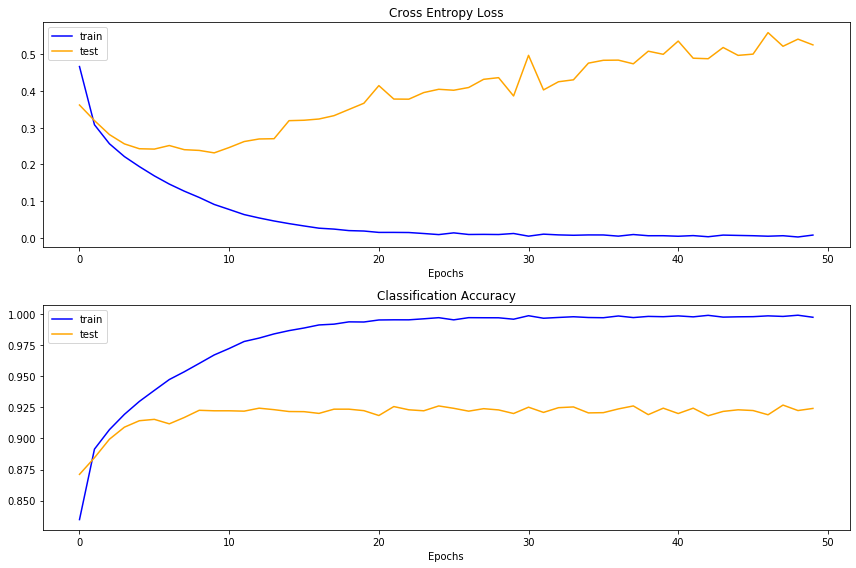

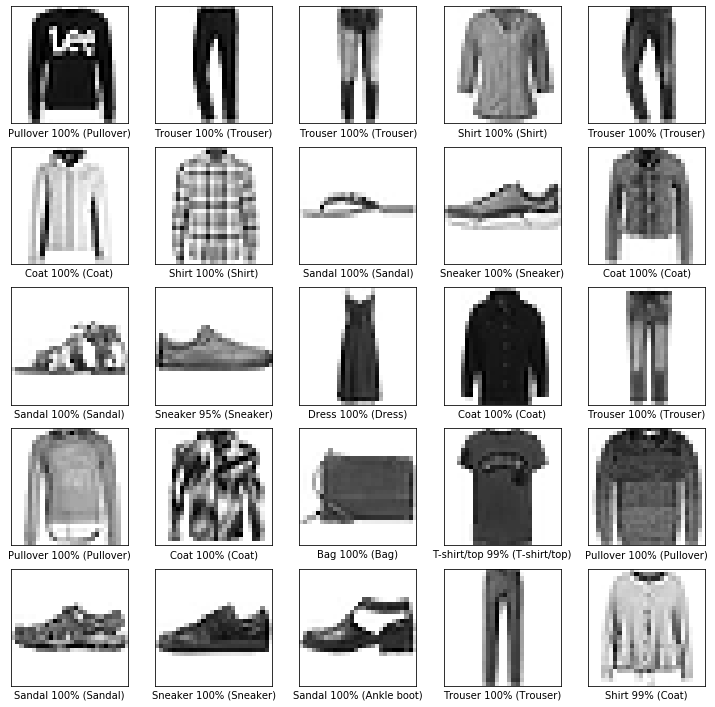

In [92]:
import matplotlib.pyplot as plt

  # plot diagnostic learning curves
def diagnostics(histories):
  for i in range(len(histories)):
    plt.figure(figsize=(12,8))
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['acc'], color='blue', label='train')
    plt.plot(histories[i].history['val_acc'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot model
diagnostics(histories)


# function that calculates the percent of correctly predicted labels compared to 
# true labels. The output is an image with its corresponding predicted label,
# the probability for the predicted label and true label. The color of the xlabel 
# indicates if the correction is correct (this doesn't show in the actual image, 
# and I don't know why...)

predictions = model.predict(test_images)

def image_percent(i, predictions, true_label, img): 
  predictions,true_label,img=predictions,true_label[i],img[i].reshape(28,28)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img,cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions)

  if predicted_label == np.argmax(true_label):
    color = 'blue'
  else:
    color = 'red' 

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions),
                                class_names[int(np.argmax(true_label))],
                                color=color))

# plot the first 25 images
nrows=5
ncols=5
plt.figure(figsize=(2.5*nrows,2.5*ncols))
for i in range(1,nrows*ncols+1):
    plt.subplot(nrows,ncols,i)
    image_percent(i,predictions[i],test_labels,test_images)
plt.show()

  

**Transfer learning**

Transfer learning according to Ian Goodfellow et al. (2016) in *Deep learning* it can be defined as:   

"*Situation where what has been learned in one setting is exploited to improve generalization in another setting.*"

Basically, it means that ... 

So in transfer learning you can leverage knowledge (features, weights etc) from previously trained models for training newer models and this offer some advantages, for example, it can be useful for dealing with problems such as having less data for the newer task. 

(60000, 32, 32, 3)
(10000, 32, 32, 3)
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling

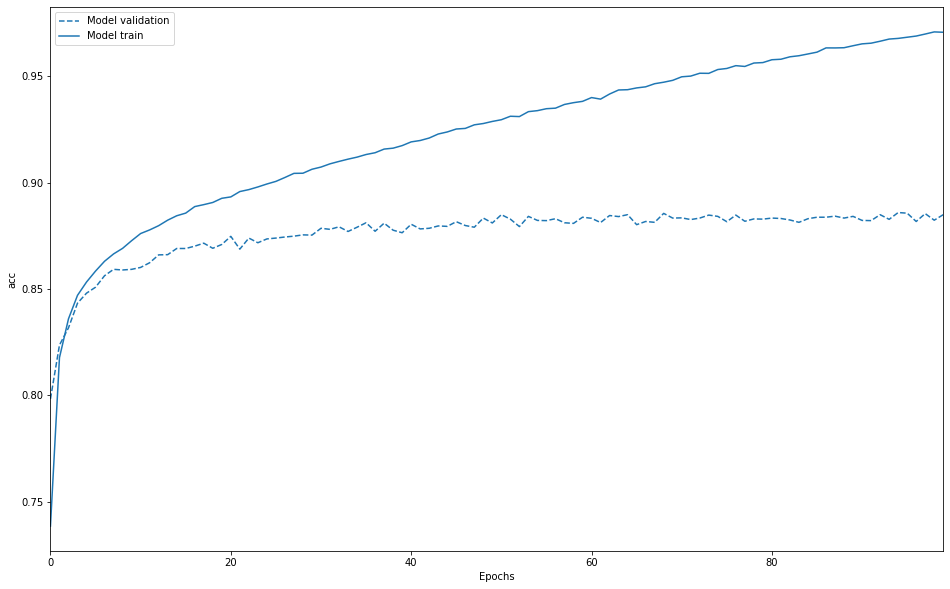

In [78]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
import pandas as pd
import numpy as np 
import cv2


def resize(images): 
  scale = 1.15  # images must 32 px or larger to be used as input for vgg16
  resized_train = []
  for i in range(len(images)): 
    # make images 3-channeled
    train_temp = np.squeeze(np.stack((images[i],) * 3, -1))
    width = int(train_temp.shape[1] * scale)
    height = int(train_temp.shape[0] * scale)
    dim = (width, height)
    # resize image
    resized_train.append(cv2.resize(train_temp, dim, 
                                    interpolation = cv2.INTER_AREA))
  return resized_train 

# resize training and testing images
resize_train = resize(train_images)
resize_val = resize(test_images)

# check size
print(np.array(resize_train).shape) 
print(np.array(resize_val).shape) 

# get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

# freeze the VGG16 parameters 
model_vgg16_conv.trainable = False
for layer in model_vgg16_conv.layers:
    layer.trainable = False

# create your own input format 
input = Input(shape=(32,32,3),name = 'image_input')

# use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

# add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

# create your own model 
my_vgg_model = Model(inputs=input, outputs=x)
my_vgg_model.summary()


my_vgg_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              metrics=['accuracy'])


BS = 100
EPOCHS=100

history = my_vgg_model.fit(x=np.array(resize_train), y=train_labels,
                    validation_data=(np.array(resize_val), test_labels),
                    batch_size=BS,
                    epochs=EPOCHS,
                    verbose=1)

def plot_models(histories:list, key:str): 
  plt.figure(figsize=(16,10))

  for name, history in histories: 
    val = plt.plot(history.epoch, history.history['val_'+key], '--',
                   label=name.title()+' validation')
    plt.plot(history.epoch,history.history[key], color=val[0].get_color(), 
             label=name.title()+' train')
  plt.xlabel('Epochs')
  plt.ylabel(key)
  plt.legend()
  plt.xlim([0,max(history.epoch)])
  plt.show()

plot_models([('Model', history)],  
               "acc")

## Results 

(It should work to click on the links of the images. If not, I'm sorry)

### Experiment 1 - Changing kernel size and stride

(all tests below implement drop out and batch size = 64) 



*   kernel size (3,3) & stride 1
[Plot showing histories and cross entropy losses (train, validation) for the own built CNN model using kernel size 3 and stride 1](https://drive.google.com/file/d/1eMzLZgrY-gslcO4LNlTQIYKNRaDxnnhm/view?usp=sharing)
*   kernel size (7,7) &  stride 1
[Plot showing histories and cross entropy losses (train, validation) for the own built CNN model using kernel size 7 and stride 1](https://drive.google.com/file/d/1rKrsy12p_01vehitCKJdXOxlsr4bqLFj/view?usp=sharing)
*   kernel size (7,7) &  stride 2 
[Plot showing histories and cross entropy losses (train, validation) for the own built CNN model using kernel size 7 and stride 2](https://drive.google.com/file/d/1T6bwl41u8QOTf9uVnLSUEomERpTQmUiH/view?usp=sharing)

Image showing the first 25 classified image with accurate label prediction rates respectively (looked sort of similiar for all runs tbh). 
[25 classified images with corresponding correctly predicted label rates](https://drive.google.com/file/d/1wNU7OfaXYrZFdFNNfg21LCxZzm3ipdnK/view?usp=sharing)

### Experiment 2 - Data augmentation 

[Plot showing histories and cross entropy losses for run not utilizing data augmentation. (k_size = (7,7), stride = 1)](https://drive.google.com/file/d/152YqgTMpjseH7T7liYqRfIgyXXqk_pth/view?usp=sharing)

Image in bullet point 2 in above section shows result using data augmentation.  

### Experiment 3 - Regularization methods

*   Drop out
[Image of histories, losses for train, val using no data augmentation and no drop out](https://drive.google.com/file/d/1niMjDEeiMOlsNxWkZ7eC4dBMvkBfukOy/view?usp=sharing)
*   Batch normalization 



### Experiment 4 - Transfer learning

[Plot showing histories (train, validation) for the model using transfer learning](https://drive.google.com/file/d/149h3fTEP9h0B_AcWQyWz4Mcv-JQr0xya/view?usp=sharing)

## Discussion

*Playing around with kernel size & stride*

Overall, the experiments show that increasing stride when using a larger filter size decreases accuracy for both training and test data. This makes sense considering that we are acutally retrieving less information from the images along the sequence as we are jumping twice the distance (in the case for bullet point 2), hence left with a smaller (less pixels) compared to when stride 1 is used. Similarly trend is seen when increasing kernel size, even when keeping them relatively small, but keeping in mind that our images have really low resolution. 

*Data augmentation*

In the beginning, using data augmentation heavily decreased accuracy on validation data. I first believed this was because my model didn't have enough capacity, so I added another convolutional layer. However, this did not solve the issue. After I inspected the generated augmentated images, I realized that they were the issue. The images had gotten way too distorted to a point were the clothing items were not recognizable anymore. Therefore, I adjusted the parameters in ImageDataGenerator, and the accuracy on validation data increased from ~10-20% to ~92%-93% after 50 epochs, a clear improvement! Crap in, crap out, as they say. 

The plots in the results section also show that accuracy for validation data declines (and cross entropy loss inclines) compared to training when data augmentation is not used. It rather looks like the model starts to overfit the training data, possbily because it has too many parameters in relation to amount of input data. Therefore increasing the amount of input data can aid in reducing overfitting. Although, I wonder if I changed the parameters so much that the augmented images barely look different to the original images, and therefore I'm essentially just feeding almost copies of the same images to the model. 

*Regularization*

The plot in the result section where drop out is not used show a large discrepancy between train and validation trend for both loss and accuracy, indicating that drop out actually helps with not over-fitting the model (compare it to the plot in bullet point 2 under Experiment 1). Further work includes changing the fraction and position of the drop out layers to see if that makes any difference. 


*Transfer learning*

The plot indicates over-fitting as we can see the accuracy for the training data steadily increasing while the accuracy for the test data plateaus at ~88% after around 30 epochs. Seeing as this model have a large number of learnable parameters (18,923,530 to be exact), this result makes sense, we have too much capacity for the input data. It would be interesting to continue working on this model and implementing, for example, data augmentation and drop out, to see if it helps with reducing over-fitting. Also, I don't know if it makes a difference using different pre-trained models, I just choose VGG16 because I found many tutorials using it.  

